In [1]:
!which python

/home/shiya/anaconda3/envs/music/bin/python


In [49]:
import glob
import os
import random

import librosa
import librosa.display
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scipy.stats
import seaborn as sns
import tensorflow as tf
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split
from tensorflow.keras import datasets, layers, models

from spec_generator_sequence import spec_generator
from spectrogram_class import spectrogram


# Preprocessing 

This is a successive notebook after the EDA notebooks.

After the EDA analysis, we can proceed to perform the preprocessing for audio. We will be working will spectrogram, as a spectrogram contains the spatial and temporal information of a audio files.

We will be utilizing Librosa package for spectrogram generation and augmentation. For easier implementation, we have defined a spectrogram class to perform all the procedures. Please refer to __spectrogram_class.py__ in the same folder for more information.

In [3]:
spectrogram

spectrogram_class.spectrogram

Let's have a look at what a spectrogram looks like

In [4]:
print(tf.config.list_physical_devices('GPU'))

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


2022-08-05 22:38:06.232805: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-08-05 22:38:06.239035: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-08-05 22:38:06.239835: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero


In [5]:
hop_length = 4096
win_length = 1024
n_fft = 1024

We have randomly picked a audio file in OrchideaSOL to showcase the spectrogram.

In [6]:
%%time
test_spec = spectrogram('PluckedStrings/Harp/pizzicato_bartok/Hp-pizz_bartok-G3-ff-N-N.wav', preprocess = False, 
                           trunc_off = True)

# To demonstrate that the test_spec is an instance on our custom defined class
# let's check its type!
type(test_spec)

CPU times: user 63.1 ms, sys: 102 ms, total: 165 ms
Wall time: 358 ms


spectrogram_class.spectrogram

We have a support function in the class to help us visualized the spectrogram, now let's have a look at what a harps looks like in spectrogram

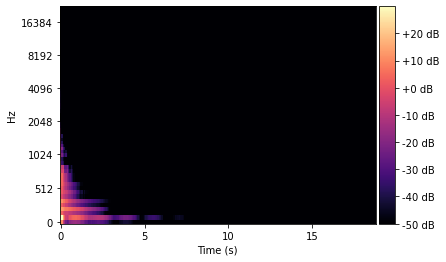

In [7]:
test_spec.plot_spec() 

Now I owe you some explanation, why am I showing you this? There are some important points to observe:

> You probably heard about the relation between a note and its soundwave frequency, for example, in piano the middle G3 note corresponds to 196 HZ. But we are not exactly seeing one horizontal line on 196 HZ. Why is that? The main reason is that the magnitude of sound wave/magnitude is additive! Let's have a closer look:

<div>
<img src="sound_addition.png" width="700"/>
</div>

(screenshot captured from our lord and savior, [3Blue1Brown](https://www.youtube.com/channel/UCYO_jab_esuFRV4b17AJtAw).

> Althought the resulting soundwave is of frequency of 196 HZ, it is actually a combination of soundwave of different frequencies. This is exactly the same note for piano and violin sounds different! Imagine a world where a ***tuba, harp, tuna and your cat*** sound the same, what a horrible world...

---

This is actually why throughout the project, we have decided to use neural network to perform the music transcription, a convolutional network or RNN are able to capture the feature between spatial and temporal information across the spectrogram.

<div>
<img src="cnn.webp" width="400"/>
</div>

(A demonstration of how a CNN is [able to capture different features on a face in different layers](https://www.kdnuggets.com/2016/11/intuitive-explanation-convolutional-neural-networks.html/3).)

But before we can use the dataset into directly, we have to consider about the data augmentation. Our model should be able to perform tasks include:

* Transcribe music in a noisy environment
* Transcribe music is moderate data loss
* Still be able to tell both audio files contain violins, although the violins have different sound signature

But how can our model learn these difference if our data is perfectly clean, and only contain audio files from the same instruments. That is where data augmentation comes in.

## Data augmentation

We have to augmentate our data so that our training dataset match the scenario above. To achieve this, we have decided to add noise, masking and shifting to the spectrogram.

All of these function had been defined under the spectrogram class. Now let's try to visualize this.

### Adding noise

Remeber this is how our signal and spectrogram for harps looks like:

In [8]:
def plt_signal_spec(spec, xlim = None):
    fig = plt.figure(figsize = (14, 6))
    ax_1 = fig.add_subplot(121)
    ax_1.plot(spec.signal)
    if xlim:
        ax_1.set_xlim((0, xlim))
    
    ax_2 = fig.add_subplot(122)
    spec.plot_spec(ax = ax_2, db_off = True)
    if xlim:
        ax_2.set_xlim((0, xlim))
    plt.show()

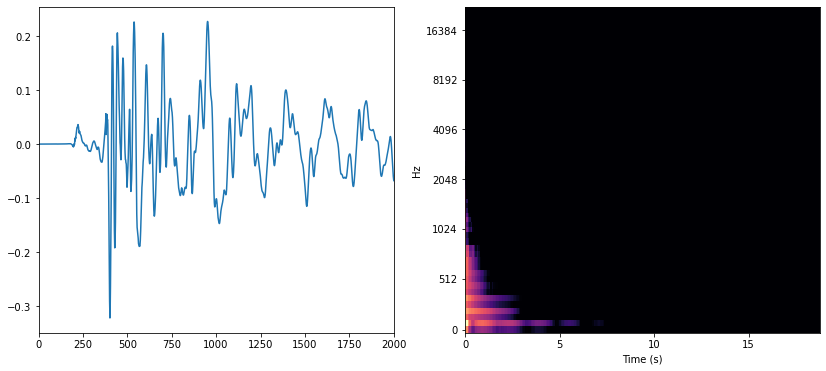

In [9]:
plt_signal_spec(test_spec, xlim = 2000)

The figure on the left is the signal directly converted from raw audio file, which represents the magnitude/pressure of the recorded audio. Whereas the figure on the right is the corresponding converted spectrogram.

We will then add random noise to the signal, before converting to the spectrogram, the signal is added based on the normal distribution of the maximum value of the signal.

In [10]:
test_spec_noise = spectrogram('PluckedStrings/Harp/pizzicato_bartok/Hp-pizz_bartok-G3-ff-N-N.wav', preprocess = False, 
                           trunc_off = True)
test_spec_noise.add_noise(noise_factor = 0.2)

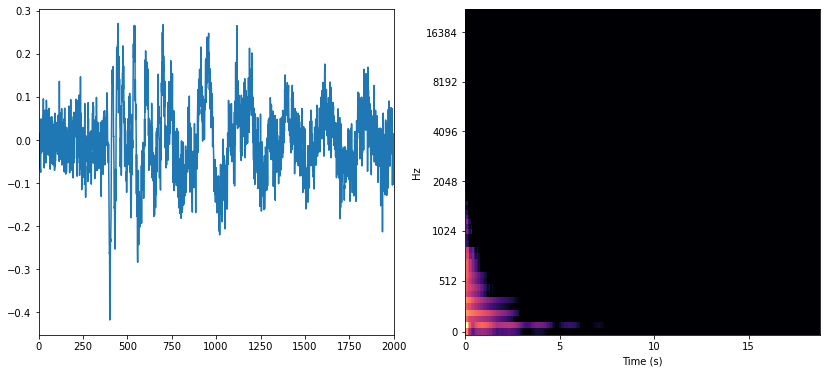

In [11]:
plt_signal_spec(test_spec_noise, xlim = 2000)

Now there is some fuzziness going on in the signal! However, since the magnitude of the mel spectrogram is log scaled, it isn't obvious in the right figure. 

> Note that the in practice, we don't add so much fuzziness in our training, the increased noise factor is for demonstration purpose only.

### Spectrogram masking

Another technique we used is the spectrogram masking, the masking function will randomly set the magnitude of spectrogram into 0, across the time and frequency of the spectrogram. 

In [12]:
test_spec_mask = spectrogram('PluckedStrings/Harp/pizzicato_bartok/Hp-pizz_bartok-G3-ff-N-N.wav', preprocess = False, 
                           trunc_off = True)
test_spec_mask.mask_spec()

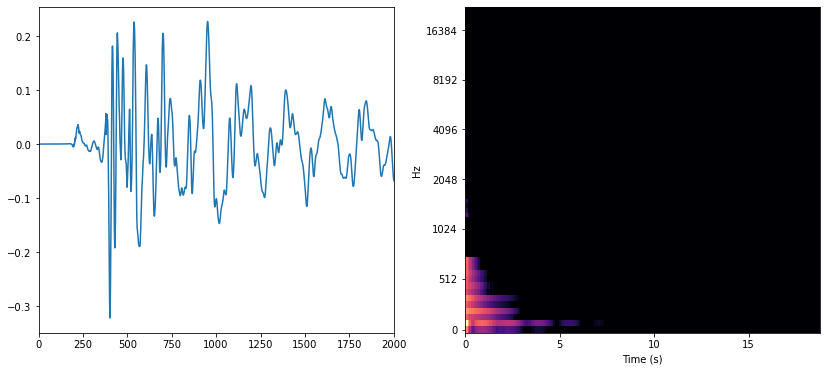

In [13]:
plt_signal_spec(test_spec_mask, xlim = 2000)

Note how we have remove chunks of the frequency and time dimension of the spectrogram. If it's not, run a few more time, it's random anyway.

### Spectrogram shifting 

Since in our audio files, the recording always starts at the beginning, and there is always a few seconds of silence before the recording ends, we will need to shift the spectrogram, so that the machine learning models doesn't depends too much on the beginning of the time slices.

In [14]:
test_spec_shift = spectrogram('PluckedStrings/Harp/pizzicato_bartok/Hp-pizz_bartok-G3-ff-N-N.wav', preprocess = False, 
                           trunc_off = True)
test_spec_shift.shift_spec(max_sec = 5)

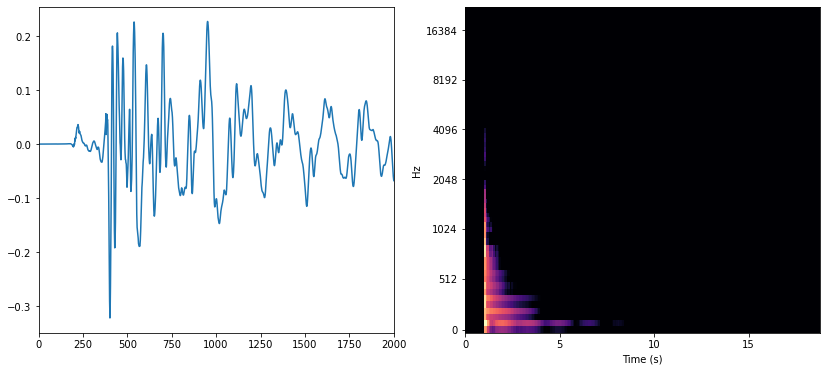

In [15]:
plt_signal_spec(test_spec_shift, xlim = 2000)

Note the now the spectrogram is now shift to the right of time, we have set the maximum time it can shift for 5 seconds for demonstration purpose.

### Spectrogram truncation

Since we have audio files of different length, we will need to preprocess it in a way that all of the sample have the same dimension as a numpy array. To do this we will simply be padding the numpy array as zeros, or trimming the last few seconds of the recording. The truncation is applied by default when the spectrogram class initialization is called.

Now to get the size of our input (to be fed into the model), we wil simply run a sample, and acquire the shape from the numpy array.

In [16]:
%%time
sample = spectrogram('PluckedStrings/Harp/pizzicato_bartok/Hp-pizz_bartok-G3-ff-N-N.wav', 
                    hop_length = hop_length, n_mels = 512,
                    n_fft = n_fft)

CPU times: user 145 ms, sys: 156 ms, total: 301 ms
Wall time: 433 ms


In [17]:
spec_shape = sample.spec.shape
spec_shape

(512, 500)

Now that we have the spectrogram ready for out training, we can use the instrument and pitch data in the metadata dataframe.

In [18]:
meta_df = pd.read_csv('../data/OrchideaSOL_metadata.csv')
meta_df.head()

,Path,Family (abbr.),Family (in full),Instrument (abbr.),Instrument (in full),Technique (abbr.),Technique (in full),Pitch,Pitch ID (if applicable),Dynamics,Dynamics ID (if applicable),Instance ID,Mute (abbr.),Mute (in full),String ID (if applicable),Needed digital retuning,Fold
0,Brass/Bass_Tuba+sordina/ordinario/BTb+S-ord-A#...,Brass,Brass,BTb,Bass Tuba,ord,ordinario,A#0,22.0,f,3.0,0.0,S,Sordina,NaN,False,2
1,Brass/Bass_Tuba+sordina/ordinario/BTb+S-ord-A#...,Brass,Brass,BTb,Bass Tuba,ord,ordinario,A#0,22.0,p,1.0,0.0,S,Sordina,NaN,True,0
2,Brass/Bass_Tuba+sordina/ordinario/BTb+S-ord-A#...,Brass,Brass,BTb,Bass Tuba,ord,ordinario,A#1,34.0,f,3.0,0.0,S,Sordina,NaN,True,1
3,Brass/Bass_Tuba+sordina/ordinario/BTb+S-ord-A#...,Brass,Brass,BTb,Bass Tuba,ord,ordinario,A#1,34.0,p,1.0,0.0,S,Sordina,NaN,True,2
4,Brass/Bass_Tuba+sordina/ordinario/BTb+S-ord-A#...,Brass,Brass,BTb,Bass Tuba,ord,ordinario,A#2,46.0,f,3.0,0.0,S,Sordina,NaN,True,1


In [19]:
meta_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13265 entries, 0 to 13264
Data columns (total 17 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   Path                         13265 non-null  object 
 1   Family (abbr.)               13265 non-null  object 
 2   Family (in full)             13265 non-null  object 
 3   Instrument (abbr.)           13265 non-null  object 
 4   Instrument (in full)         13265 non-null  object 
 5   Technique (abbr.)            13265 non-null  object 
 6   Technique (in full)          13265 non-null  object 
 7   Pitch                        13265 non-null  object 
 8   Pitch ID (if applicable)     13162 non-null  float64
 9   Dynamics                     13265 non-null  object 
 10  Dynamics ID (if applicable)  12646 non-null  float64
 11  Instance ID                  13262 non-null  float64
 12  Mute (abbr.)                 13265 non-null  object 
 13  Mute (in full)  

In [20]:
meta_df.describe()

,Pitch ID (if applicable),Dynamics ID (if applicable),Instance ID,String ID (if applicable),Fold
count,13162.000000,12646.000000,13262.000000,7516.000000,13265.000000
mean,63.842653,2.073857,0.848138,2.360298,2.000000
std,16.512067,1.329919,1.177874,1.196041,1.414267
min,20.000000,0.000000,0.000000,1.000000,0.000000
25%,52.000000,2.000000,0.000000,1.000000,1.000000
50%,64.000000,2.000000,0.000000,2.000000,2.000000
75%,76.000000,3.000000,2.000000,3.000000,3.000000
max,109.000000,4.000000,12.000000,6.000000,4.000000


In [21]:
meta_df.isnull().sum()

Path                              0
Family (abbr.)                    0
Family (in full)                  0
Instrument (abbr.)                0
Instrument (in full)              0
Technique (abbr.)                 0
Technique (in full)               0
Pitch                             0
Pitch ID (if applicable)        103
Dynamics                          0
Dynamics ID (if applicable)     619
Instance ID                       3
Mute (abbr.)                      0
Mute (in full)                    0
String ID (if applicable)      5749
Needed digital retuning           0
Fold                              0
dtype: int64

In [22]:
meta_df['Instrument (in full)'].value_counts()

Violin            1987
Viola             1952
Contrabass        1636
Cello             1593
Accordion          872
Trombone           670
Trumpet in C       590
French Horn        589
Flute              529
Harp               507
Bass Tuba          500
Clarinet in Bb     406
Alto Saxophone     377
Bassoon            358
Guitar             353
Oboe               346
Name: Instrument (in full), dtype: int64

We don'really care about the pitchID, Dynamics Id and String ID.

We can see some degree of bias in the instrument classes.

## First baseline model is to predict the instrument present in the audio file.


In [23]:
train_df, test_df = train_test_split(meta_df, train_size = 0.7, random_state = 42)

In [24]:
print('The number of rows for the training data is ', train_df.shape[0])
print('The number of rows for the test data is ', test_df.shape[0])

The number of rows for the training data is  9285
The number of rows for the test data is  3980


In [25]:
BATCH_SIZE = 32

train_generator = tf.data.Dataset.from_generator(lambda: spec_generator(train_df, BATCH_SIZE, 
                    add_channel = True, live_generation = True), 
                    output_types=(tf.float32, tf.int32),
                    output_shapes = ((BATCH_SIZE, spec_shape[0], spec_shape[1], 1), 
                    (BATCH_SIZE, 16))).prefetch(5)
eval_generator = tf.data.Dataset.from_generator(lambda: spec_generator(test_df, BATCH_SIZE, 
                    add_channel = True, live_generation = True,), 
                    output_types=(tf.float32, tf.int32), 
                    output_shapes = ((BATCH_SIZE, spec_shape[0], spec_shape[1], 1), 
                    (BATCH_SIZE, 16))).prefetch(5)


2022-08-05 22:38:12.127129: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-08-05 22:38:12.127905: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-08-05 22:38:12.128706: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-08-05 22:38:12.129253: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zer

In [26]:
train_generator

<PrefetchDataset element_spec=(TensorSpec(shape=(32, 512, 500, 1), dtype=tf.float32, name=None), TensorSpec(shape=(32, 16), dtype=tf.int32, name=None))>

In [27]:
model = models.Sequential()
model.add(layers.InputLayer((spec_shape[0], spec_shape[1], 1), batch_size = BATCH_SIZE, 
                                    dtype = tf.float32))
model.add(layers.Conv2D(15, (15, 200), strides=(10, 10), activation='relu'))
# , input_shape = (spec_shape[0], spec_shape[1], 1)))
model.add(layers.MaxPool2D((5, 2)))
model.add(layers.Flatten())
model.add(layers.Dense(16, activation = 'sigmoid'))
model.build()

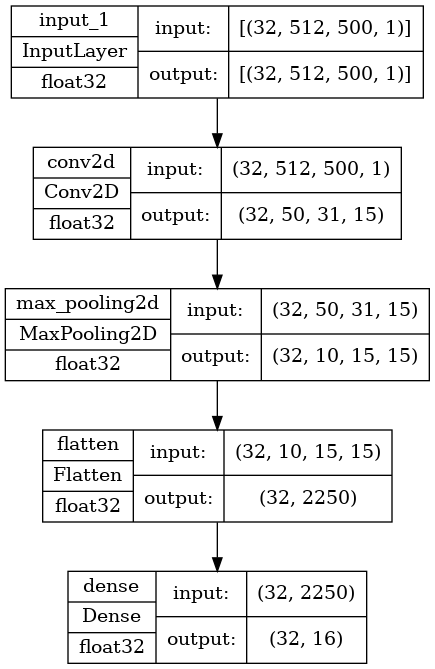

In [28]:
tf.keras.utils.plot_model(model, show_shapes = True, show_dtype= True)

In [29]:
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0005),
              loss=tf.keras.losses.BinaryCrossentropy(),
              metrics=['accuracy'])
print(model.metrics)

[]


In [30]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (32, 50, 31, 15)          45015     
                                                                 
 max_pooling2d (MaxPooling2D  (32, 10, 15, 15)         0         
 )                                                               
                                                                 
 flatten (Flatten)           (32, 2250)                0         
                                                                 
 dense (Dense)               (32, 16)                  36016     
                                                                 
Total params: 81,031
Trainable params: 81,031
Non-trainable params: 0
_________________________________________________________________


In [31]:
from datetime import datetime
datetime.now().strftime('%Y%m%d_%H%M%S')


'20220805_223813'

In [32]:
train_df.head(2)

,Path,Family (abbr.),Family (in full),Instrument (abbr.),Instrument (in full),Technique (abbr.),Technique (in full),Pitch,Pitch ID (if applicable),Dynamics,Dynamics ID (if applicable),Instance ID,Mute (abbr.),Mute (in full),String ID (if applicable),Needed digital retuning,Fold
4851,Strings/Contrabass/pizzicato_bartok/Cb-pizz_ba...,Strings,Violin Family,Cb,Contrabass,pizz_bartok,pizzicato_bartok,F3,53.0,ff,4.0,0.0,N,None,1.0,False,1
12565,Winds/Oboe+sordina/ordinario/Ob+S-ord-E6-mf-N-...,Winds,Woodwinds,Ob,Oboe,ord,ordinario,E6,88.0,mf,2.0,0.0,S,Sordina,NaN,False,4


In [33]:
%load_ext tensorboard

In [35]:
ckpt_callback = tf.keras.callbacks.ModelCheckpoint(
    f"../models/baseline_checkpoint/{datetime.now().strftime('%Y%m%d_%H%M%S')}_{{epoch:02d}}_model", 
                                                    monitor='val_accuracy')
early_callback = tf.keras.callbacks.EarlyStopping(monitor = 'val_accuracy', patience = 2, 
                                                        restore_best_weights = True)
log_dir = "logs/fit/" + datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)


history = model.fit(train_generator, epochs = 10, verbose=1, 
                    validation_data = eval_generator, 
                    validation_freq= 1, 
                    # use_multiprocessing=True, workers = 2, 
                    callbacks=[ckpt_callback, early_callback, tensorboard_callback])

Epoch 1/10


2022-08-05 22:38:59.159687: I tensorflow/stream_executor/cuda/cuda_dnn.cc:384] Loaded cuDNN version 8100
2022-08-05 22:38:59.719831: I tensorflow/core/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2022-08-05 22:38:59.720868: I tensorflow/core/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2022-08-05 22:38:59.720920: W tensorflow/stream_executor/gpu/asm_compiler.cc:80] Couldn't get ptxas version string: INTERNAL: Couldn't invoke ptxas --version
2022-08-05 22:38:59.722054: I tensorflow/core/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2022-08-05 22:38:59.722155: W tensorflow/stream_executor/gpu/redzone_allocator.cc:314] INTERNAL: Failed to launch ptxas
Relying on driver to perform ptx compilation. 
Modify $PATH to customize ptxas location.
This message will be only logged once.


    290/Unknown - 2144s 7s/step - loss: 0.4439 - accuracy: 0.2172

INFO:tensorflow:Assets written to: ../models/baseline_checkpoint/20220805_223850_01_model/assets


INFO:tensorflow:Assets written to: ../models/baseline_checkpoint/20220805_223850_01_model/assets


290/290 [==============================] - 2979s 10s/step - loss: 0.4439 - accuracy: 0.2172 - val_loss: 0.3300 - val_accuracy: 0.2256
Epoch 2/10
290/290 [==============================] - ETA: 0s - loss: 0.2875 - accuracy: 0.2376

INFO:tensorflow:Assets written to: ../models/baseline_checkpoint/20220805_223850_02_model/assets


INFO:tensorflow:Assets written to: ../models/baseline_checkpoint/20220805_223850_02_model/assets


290/290 [==============================] - 2677s 9s/step - loss: 0.2875 - accuracy: 0.2376 - val_loss: 0.2696 - val_accuracy: 0.2321
Epoch 3/10
290/290 [==============================] - ETA: 0s - loss: 0.2597 - accuracy: 0.2405

INFO:tensorflow:Assets written to: ../models/baseline_checkpoint/20220805_223850_03_model/assets


INFO:tensorflow:Assets written to: ../models/baseline_checkpoint/20220805_223850_03_model/assets


290/290 [==============================] - 2692s 9s/step - loss: 0.2597 - accuracy: 0.2405 - val_loss: 0.2537 - val_accuracy: 0.2608
Epoch 4/10
290/290 [==============================] - ETA: 0s - loss: 0.2366 - accuracy: 0.2450

INFO:tensorflow:Assets written to: ../models/baseline_checkpoint/20220805_223850_04_model/assets


INFO:tensorflow:Assets written to: ../models/baseline_checkpoint/20220805_223850_04_model/assets


290/290 [==============================] - 2617s 9s/step - loss: 0.2366 - accuracy: 0.2450 - val_loss: 0.2379 - val_accuracy: 0.2452
Epoch 5/10
290/290 [==============================] - ETA: 0s - loss: 0.2301 - accuracy: 0.2548

INFO:tensorflow:Assets written to: ../models/baseline_checkpoint/20220805_223850_05_model/assets


INFO:tensorflow:Assets written to: ../models/baseline_checkpoint/20220805_223850_05_model/assets


290/290 [==============================] - 2469s 9s/step - loss: 0.2301 - accuracy: 0.2548 - val_loss: 0.2332 - val_accuracy: 0.2462


In [39]:
model.save('../models/new_baseline/')

INFO:tensorflow:Assets written to: ../models/new_baseline/assets


INFO:tensorflow:Assets written to: ../models/new_baseline/assets


In [51]:
import pickle

def save_history(history, path):
    with open(path, 'wb+') as f:
        pickle.dump(history, f)

    # with open(path, 'rb') as f:
    #     test = pickle.load(f)

In [53]:
save_history(history.history, '../models/new_baseline/history.pkl')

In [38]:
# model = tf.keras.models.load_model('../models/new_baseline/')

OSError: SavedModel file does not exist at: ../models/new_baseline//{saved_model.pbtxt|saved_model.pb}

In [41]:
history.history.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

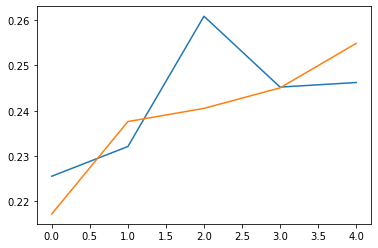

In [48]:
plt.plot(history.history['val_accuracy'])
plt.plot(history.history['accuracy'])

In [ ]:
# model.save_weights('../models/baseline_checkpoint/20220704_153658_model/')

In [50]:
model.evaluate_generator(eval_generator)

KeyboardInterrupt: 

In [54]:
prediction_generator = spec_generator(test_df, batch_size=len(test_df), add_channel=True,
                                        live_generation = True, preprocess = False)

TypeError: __init__() got an unexpected keyword argument 'preprocess'

In [ ]:
prediction_feature, prediction_label = prediction_generator.__getitem__(0)

In [ ]:
model_prediction_tuple = model.predict()

In [ ]:
classification_report()

In [ ]:
model(np.reshape(random_train, (1, 1025, 807, 1)), training= False)

## Deeper model


In [ ]:
model_2conv = models.Sequential()
model_2conv.add(layers.InputLayer((spec_shape[0], spec_shape[1], 1), dtype = tf.float64))
model_2conv.add(layers.Conv2D(30, (200, 20), activation='relu'))
# , input_shape = (spec_shape[0], spec_shape[1], 1)))
model_2conv.add(layers.MaxPool2D((5, 5)))
model_2conv.add(layers.Conv2D(20, (20, 5), activation = 'relu'))
model_2conv.add(layers.Flatten())
model_2conv.add(layers.Dense(16, activation = 'sigmoid'))
model_2conv.build()

In [ ]:
tf.keras.utils.plot_model(model_2conv, show_shapes = True, show_dtype= True)

In [ ]:
model_2conv.summary()